# Analyzing Code Performance

### Timing Your Code

In [1]:
def slow_way_to_calculate_mode(list_of_numbers):
    result_dict = {}
    for i in list_of_numbers:
        if i not in result_dict:
            result_dict[i] = 1
        else:
            result_dict[i] += 1

    mode_vals = []
    max_frequency = max(result_dict.values())
    for key, value in result_dict.items():
        if value == max_frequency:
            mode_vals.append(key)

    return mode_vals

In [2]:
slow_way_to_calculate_mode([4, 5, 5, 6])

[5]

In [3]:
import numpy as np

In [4]:
help(np.random.randint)

Help on built-in function randint:

randint(...) method of numpy.random.mtrand.RandomState instance
    randint(low, high=None, size=None, dtype=int)

    Return random integers from `low` (inclusive) to `high` (exclusive).

    Return random integers from the "discrete uniform" distribution of
    the specified dtype in the "half-open" interval [`low`, `high`). If
    `high` is None (the default), then results are from [0, `low`).

    .. note::
        New code should use the `~numpy.random.Generator.integers`
        method of a `~numpy.random.Generator` instance instead;
        please see the :ref:`random-quick-start`.

    Parameters
    ----------
    low : int or array-like of ints
        Lowest (signed) integers to be drawn from the distribution (unless
        ``high=None``, in which case this parameter is one above the
        *highest* such integer).
    high : int or array-like of ints, optional
        If provided, one above the largest (signed) integer to be drawn
     

In [23]:
import numpy as np

random_integers = np.random.randint(1, 1_000_000, 1_000_000)

In [24]:
import time

start = time.time()
slow_way_to_calculate_mode(random_integers)
end = time.time()

print(end - start)

0.2510986328125


In [25]:
%%timeit
slow_way_to_calculate_mode(random_integers)

226 ms ± 5.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Profiling Your Code

### `cProfile`

In [26]:
from collections import Counter
import numpy as np

In [27]:
def mode_simple_using_counter(list_of_numbers):
    c = Counter(list_of_numbers)
    return c.most_common(1)[0][0]

In [28]:
%%timeit
mode_simple_using_counter(random_integers)

177 ms ± 3.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
def mode_using_counter(n_integers):
    random_integers = np.random.randint(1, 1_000_000, n_integers)
    c = Counter(random_integers)
    return c.most_common(1)[0][0]

In [30]:
mode_using_counter(1_000_000)

729008

In [31]:
%%timeit
mode_using_counter(1_000_000)

189 ms ± 6.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%%prun
mode_using_counter(1_000_000)

         579 function calls (573 primitive calls) in 0.211 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.181    0.181    0.181    0.181 {built-in method _collections._count_elements}
        4    0.019    0.005    0.019    0.005 {built-in method builtins.max}
      2/1    0.006    0.003    0.211    0.211 <string>:1(<module>)
        1    0.004    0.004    0.004    0.004 {method 'randint' of 'numpy.random.mtrand.RandomState' objects}
        1    0.000    0.000    0.185    0.185 decorator.py:232(fun)
      2/1    0.000    0.000    0.211    0.211 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'execute' of 'sqlite3.Connection' objects}
        2    0.000    0.000    0.000    0.000 zmqstream.py:546(_run_callback)
       14    0.000    0.000    0.000    0.000 socket.py:623(send)
        2    0.000    0.000    0.181    0.090 {method '__exit__' of 'sqlite3.Connection' objects

In [33]:
%load_ext snakeviz

In [34]:
%%snakeviz
mode_using_counter(10_000_000)

 
*** Profile stats marshalled to file '/tmp/tmp1vwr8p8d'.
Embedding SnakeViz in this document...
<function display at 0x7f2c23564fe0>


`line_profiler`

In [35]:
%load_ext line_profiler

In [36]:
%lprun -f mode_using_counter mode_using_counter(10000000)

Timer unit: 1e-09 s

Total time: 3.12342 s
File: /tmp/ipykernel_104879/2096954180.py
Function: mode_using_counter at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def mode_using_counter(n_integers):
     2         1   42247566.0    4e+07      1.4      random_integers = np.random.randint(1, 1_000_000, n_integers)
     3         1 3067340146.0    3e+09     98.2      c = Counter(random_integers)
     4         1   13830012.0    1e+07      0.4      return c.most_common(1)[0][0]

```bash
$ memray run mode_using_counter.py
```

## Time Complexity

In [37]:
def weighted_mean(list_of_numbers, weights):
    running_total = 0
    for i in range(len(list_of_numbers)):
        running_total += (list_of_numbers[i] * weights[i])
    return (running_total/sum(weights))

In [38]:
def covariance_fast(X, Y):
    avg_X = sum(X) / len(X)
    avg_Y = sum(Y) / len(Y)

    result = 0
    for i in range(len(X)):
        result += (X[i] - avg_X) * (Y[i] - avg_Y)

    return result / len(X)

In [39]:
X = np.random.randint(1, 1000, 1000)
Y = np.random.randint(1, 1000, 1000)

In [40]:
%%timeit
covariance_fast(X, Y)

417 μs ± 9.79 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [41]:
def covariance(X, Y):
    cov_sum = 0
    for i in range(len(X)):
        for j in range(len(Y)):
            cov_sum += 0.5 * (X[i] - X[j]) * (Y[i] - Y[j])
    return cov_sum / (len(X) ** 2)

In [42]:
%%timeit
covariance(X, Y)

1.07 s ± 6.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Code to generate Figure 2.3

In [43]:
import matplotlib.pyplot as plt
import numpy as np

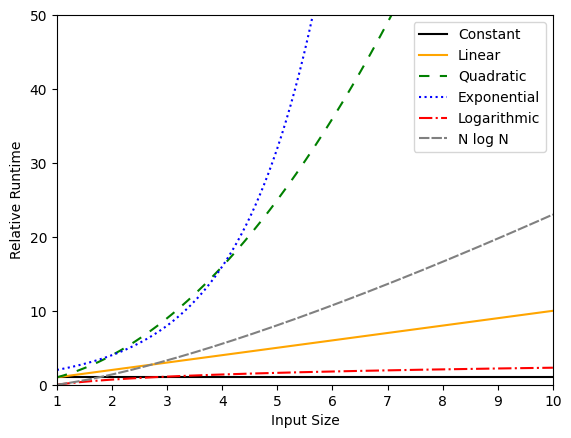

In [44]:
n = np.linspace(1, 10, 1000)
line_names = [
    "Constant",
    "Linear",
    "Quadratic",
    "Exponential",
    "Logarithmic",
    "N log N",
]

colors = ["black", "orange", "green", "blue", "red", [0.5, 0.5, 0.5]]
linestyles = ["solid", "solid", (0, (5, 5)), "dotted", "dashdot", (0, (5, 1))]
big_o = [np.ones(n.shape), n, n**2, 2**n, np.log(n), n * (np.log(n))]

fig, ax = plt.subplots()
fig.set_facecolor("white")

ax.set_ylim(0, 50)
ax.set_xlim(1, 10)
for i in range(len(big_o)):
    ax.plot(n, big_o[i], label=line_names[i], color=colors[i], linestyle=linestyles[i])
ax.set_ylabel("Relative Runtime")
ax.set_xlabel("Input Size")
ax.legend()
fig.savefig("seds_0202_v3.png", bbox_inches="tight")